FEXI implementation..Single dataset

In [ ]:
# Load the modules
import pandas as pd
import numpy as np
import nibabel as nib
import os 
import matplotlib.pyplot as plt 
from scipy.ndimage import gaussian_filter
from scipy.stats import gmean
from sklearn.linear_model import LinearRegression
from scipy.optimize import least_squares
from scipy.linalg import expm

## Set directories
dataDir = '/mnt/c/Users/z34213pv/The University of Manchester Dropbox/Paulina Villasenor/LPS_project/pilot_data/BBB/fexi/'
outputDir = '/mnt/c/Users/z34213pv/The University of Manchester Dropbox/Paulina Villasenor/LPS_project/pilot_data/BBB/fexi/results/'

# Load the FEXI data and ROI
eq_data = nib.load(os.path.join(dataDir, 'working_unfiltered_bbb.nii.gz'))
bf_data = nib.load(os.path.join(dataDir, 'working_filtered_bbb.nii.gz'))
roi_data = nib.load(os.path.join(dataDir, 'gm_blood.nii.gz'))

## Set parameters
nb = 2 #fixes f1 and sets D2_init = ADC_tm (for the CCXR model)
td = 10e-3 -(0.4e-3/3) 
deltac = 1.5e-3 
dZslab = 30 #slab thickness of the initial 90 pulse and diffusion filter
dZ = 4 #slice thickness of the excitation storage pulses and readout
bw_storage = 2000 # bandwidth of the 90 degree storage pulse
ts = 2.19e-3/2
b0 = 0 #the b-zero // this can be dynbamic, maybe load the bval file and set it from there***
bf = 250 #the b filter // this can be dynamic
data2fit = np.arange(0, 50)  # Use all available data points for fitting
fit2ADCeq = 0
average_before_ADC = 1 # 1 when TRUE and 0 when FALSE
tm = [25, 50, 75, 100, 125] #mixing times in ms
man_offset = 0 # 1 when TRUE and 0 when FALSE, this is to manually offset the b0 and b values to match the equilibrium ADC

#-----------------------------------------------------------------------------------

#def FEXI_fit_CCXRmodel(eq_data, bf_data, roi_data, tm, b0, bf, nb, td, deltac, dZslab, dZ, bw_storage, data2fit, fit2ADCeq, average_before_ADC):
        

im_eq = np.squeeze(eq_data.get_fdata())
im_bf = np.squeeze(bf_data.get_fdata())

# Apply Gaussian filter with sigma=20 to the 2nd slice 
im_bf0_filtered = gaussian_filter(im_bf[:, :, 1].astype(np.float64), sigma=20)
# Normalize
im_bf0_filtered_norm = im_bf0_filtered / np.max(im_bf0_filtered)
# Broadcasted division
im_bf = im_bf / im_bf0_filtered_norm[:, :, np.newaxis]  # Ensure shape match
im_eq = im_eq / im_bf0_filtered_norm[:, :, np.newaxis]

# Check images sizes
size_eq = im_eq.shape
print(f"Size of equilibrium image: {size_eq}")
size_bf = im_bf.shape
print(f"Size of filtered image: {size_bf}")

# Set the number of images per mixing time
n_images_per_tm = 7 # hard coded for now, but could be made dynamic
# Find the number of repetitions
n_reps = im_eq.shape[2] // (len(tm) * n_images_per_tm)
print(f"Number of repetitions: {n_reps}")

# Create a list of mixing times per repetition
tm_all = np.repeat(tm, n_reps)
#tm_all = np.concatenate([np.full((n_reps, 1), t) for t in tm], axis=0) # this is doing the 250 datapoints, its wrong
#print(f"Mixing times array shape: {tm_all}")

# Rotate the images 90 degrees clockwise
im_eq_rotated = np.rot90(im_eq, k=3, axes=(0, 1))
im_bf_rotated = np.rot90(im_bf, k=3, axes=(0, 1))
roi_rotated = np.rot90(roi_data.get_fdata(), k=3, axes=(0, 1))

# Display the middle slice of the rotated image --- checking the rotation
# mid_slice = im_eq_rotated.shape[2] // 2
# plt.imshow(im_eq_rotated[:, :, mid_slice], cmap='gray')
# plt.title('Equilibrium Image (Rotated, Middle Slice)')
# plt.axis('off')
# plt.show()

# # Check the roi
# plt.imshow(roi_rotated[:, :, 0], cmap='gray')
# plt.show()

# Apply mask to the images
im_eq_masked = im_eq_rotated * roi_rotated
im_bf_masked = im_bf_rotated * roi_rotated

# Display the masked images
# plt.imshow(im_eq_masked[:, :, mid_slice], cmap='gray')
# plt.title('Masked Equilibrium Image (Rotated, Middle Slice)')
# plt.axis('off')
# plt.show()
# plt.imshow(im_bf_masked[:, :, mid_slice], cmap='gray')
# plt.title('Masked Filtered Image (Rotated, Middle Slice)')
# plt.axis('off')
# plt.show()

# Index the bvalues (0 and 250, or 900... whatever is the bvalue we acquired). In this case, we will index 0 and 250*

# For the size_eq data
index_b0_eq_1 = np.arange(1, size_eq[2], 7)
index_b0_eq_2 = np.arange(3, size_eq[2], 7)
index_b0_eq_3 = np.arange(5, size_eq[2], 7)
index_bfilt_eq_1 = np.arange(2, size_eq[2], 7)
index_bfilt_eq_2 = np.arange(4, size_eq[2], 7)
index_bfilt_eq_3 = np.arange(6, size_eq[2], 7)
# For the size_bf data
index_b0_bf_1 = np.arange(1, size_bf[2], 7)
index_b0_bf_2 = np.arange(3, size_bf[2], 7)
index_b0_bf_3 = np.arange(5, size_bf[2], 7)
index_bfilt_bf_1 = np.arange(2, size_bf[2], 7)
index_bfilt_bf_2 = np.arange(4, size_bf[2], 7)
index_bfilt_bf_3 = np.arange(6, size_bf[2], 7)


# # Check the indices
# print(f"Index b0 1: {index_b0_eq_1}")
# print(f"Index b0 2: {index_b0_eq_2}")
# print(f"Index b0 3: {index_b0_eq_3}")
# print(f"Index bfilt 1: {index_bfilt_eq_1}")
# print(f"Index bfilt 2: {index_bfilt_eq_2}")
# print(f"Index bfilt 3: {index_bfilt_eq_3}")


if average_before_ADC == 1:

    ## get the ROI indices//the voxels to process
   # nmaskvox = np.count_nonzero(roi_rotated)
   # maskedvoxels = np.flatnonzero(roi_rotated)
    maskedvoxels = np.argwhere(roi_rotated)

    # # Average each slice in the ROI
    # # Squeeze the singleton dimension from roi_rotated for 2D mask
    # roi_mask_2d = (roi_rotated).astype(bool)

    im_eq_iter = []
    for i in range(im_eq_masked.shape[2]):
        temp = im_eq_masked[:, :, i]
        # Use 2D mask for indexing
        im_eq_iter.append(np.mean(temp[maskedvoxels]))
    im_eq_iter = np.array(im_eq_iter)  # Convert to numpy array

    im_bf_iter = []
    for i in range(im_bf_masked.shape[2]):
        temp2 = im_bf_masked[:, :, i]
        im_bf_iter.append(np.mean(temp2[maskedvoxels]))
    im_bf_iter = np.array(im_bf_iter)  # Convert to numpy array

    # Do geometric mean across directions
    #for eq data (b0 and b)
    im_eq_b0_gmean = gmean(np.stack([im_eq_iter[index_b0_eq_1], im_eq_iter[index_b0_eq_2], im_eq_iter[index_b0_eq_3]]), axis=0)
    im_eq_b_gmean = gmean(np.stack([im_eq_iter[index_bfilt_eq_1], im_eq_iter[index_bfilt_eq_2], im_eq_iter[index_bfilt_eq_3]]), axis=0)
    #for filter data (b0 and b)
    im_bf_b0_gmean = gmean(np.stack([im_bf_iter[index_b0_bf_1], im_bf_iter[index_b0_bf_2], im_bf_iter[index_b0_bf_3]]), axis=0)
    im_bf_b_gmean = gmean(np.stack([im_bf_iter[index_bfilt_bf_1], im_bf_iter[index_bfilt_bf_2], im_bf_iter[index_bfilt_bf_3]]), axis=0)

    # Check the shapes of the geometric means
    # print(f"Shape of equilibrium b0 geometric mean: {im_eq_b0_gmean.shape}")
    # print(f"Shape of equilibrium b geometric mean: {im_eq_b_gmean.shape}")
    # print(f"Shape of filtered b0 geometric mean: {im_bf_b0_gmean.shape}")
    # print(f"Shape of filtered b geometric mean: {im_bf_b_gmean.shape}")

    if man_offset == 1:

        im_bf_b0_gmean2 = im_bf_b0_gmean.copy() #creates a copy of the original
        y_b0 = LinearRegression().fit(tm_all[:16].reshape(-1, 1), im_bf_b0_gmean2[:16]) #fits a LM using only the fisrt 16 points of tm and the correspongin signals from im_bf_b0_gmean2
        model_b0 = y_b0.intercept_ + y_b0.coef_[0] * tm_all[16:40] #predicts the model for the next 23 points of tm (from 17 to 40) using the fitted model
        diff = model_b0[0] - im_bf_b0_gmean[16] #compares the predicted value at time point 17. The difference erpresents the possible offset/bias in the signal
        im_bf_b0_gmean2[16:40] = im_bf_b0_gmean2[16:40] + diff #applies the offset to the next 23 points of im_bf_b0_gmean2
        # Print the values of the above variables
        # print(f"y_b0 intercept: {y_b0.intercept_}")
        # print(f"y_b0 coefficient: {y_b0.coef_[0]}")
        # # Check the adjusted geometric mean
        # print(f"Adjusted geometric mean of filtered b0: {im_bf_b0_gmean2[17:40]}")

        # do the same for the bf with bvalues >0
        im_bf_b_gmean2 = im_bf_b_gmean.copy() #creates a copy of the original
        y_b = LinearRegression().fit(tm_all[:16].reshape(-1, 1), im_bf_b_gmean2[:16]) #fits a LM using only the fisrt 16 points of tm and the correspongin signals from im_bf_b_gmean2
        mode_b = y_b.intercept_ + y_b.coef_[0] * tm_all[16:40] #predicts the model for the next 23 points of tm (from 17 to 40) using the fitted model
        diff = mode_b[0] - im_bf_b_gmean[16] #compares the predicted value at time point 17. The difference erpresents the possible offset/bias in the signal
        im_bf_b_gmean2[16:40] = im_bf_b_gmean2[16:40] + diff #applies the offset to the next 23 points of im_bf_b_gmean2
        # Print the values of the above variables
        # print(f"y_b intercept: {y_b.intercept_}")
        # print(f"y_b coefficient: {y_b.coef_[0]}")
        # # Check the adjusted geometric mean
        # print(f"Adjusted geometric mean of filtered b: {im_bf_b_gmean2[17:40]}")
        # # Check the adjusted geometric means
        # print(f"Adjusted geometric mean of filtered b0: {im_bf_b0_gmean2}")
        # print(f"Adjusted geometric mean of filtered b: {im_bf_b_gmean2}")

    else:
        im_bf_b0_gmean2 = im_bf_b0_gmean.copy()  # No adjustment
        im_bf_b_gmean2 = im_bf_b_gmean.copy()  # No adjustment

    # Mono exponential decay
    ADC_eq = -(1 / (bf - b0)) * np.log(im_eq_b_gmean / im_eq_b0_gmean)
    ADC = -(1 / (bf - b0)) * np.log(im_bf_b_gmean2 / im_bf_b0_gmean2)
    # # Check the shapes of the ADC images
    # print(f"Shape of ADC equilibrium image: {ADC_eq.shape}")
    # print(f"Shape of ADC filtered image: {ADC.shape}")
    # # Check the ADC values as 1D plots
    # plt.figure()
    # plt.plot(ADC_eq, label='ADC_eq')
    # plt.title('ADC Equilibrium (1D)')
    # plt.xlabel('Index')
    # plt.ylabel('ADC_eq')
    # plt.legend()
    # plt.show() # WARNING: is not plotting exactly the same as Matlab

    # plt.figure()
    # plt.plot(ADC, label='ADC')
    # plt.title('ADC Filtered (1D)')
    # plt.xlabel('Index')
    # plt.ylabel('ADC')
    # plt.legend()
    # plt.show() # This is fine

# Calculate ADC maps    
else: 
    ADC_1_eq = -(1 / bf) * np.log(im_eq_masked[:, :, index_bfilt_eq_1] / im_eq_masked[:, :, index_b0_eq_1])
    ADC_2_eq = -(1 / bf) * np.log(im_eq_masked[:, :, index_bfilt_eq_2] / im_eq_masked[:, :, index_b0_eq_2])
    ADC_3_eq = -(1 / bf) * np.log(im_eq_masked[:, :, index_bfilt_eq_3] / im_eq_masked[:, :, index_b0_eq_3])

    ADC_1_bf = -(1 / bf) * np.log(im_bf_masked[:, :, index_bfilt_bf_1] / im_bf_masked[:, :, index_b0_bf_1])
    ADC_2_bf = -(1 / bf) * np.log(im_bf_masked[:, :, index_bfilt_bf_2] / im_bf_masked[:, :, index_b0_bf_2])
    ADC_3_bf = -(1 / bf) * np.log(im_bf_masked[:, :, index_bfilt_bf_3] / im_bf_masked[:, :, index_b0_bf_3])
    # # Show ADC maps 
    # plt.figure(figsize=(12, 8))
    # plt.subplot(2, 3, 1)
    # plt.imshow(ADC_1_eq[:, :, 0], cmap='gray')
    # plt.title('ADC 1 Equilibrium')
    # plt.axis('off')
    # plt.subplot(2, 3, 2)
    # plt.imshow(ADC_2_eq[:, :, 0], cmap='gray')
    # plt.title('ADC 2 Equilibrium')
    # plt.axis('off')
    # plt.subplot(2, 3, 3)
    # plt.imshow(ADC_3_eq[:, :, 0], cmap='gray')
    # plt.title('ADC 3 Equilibrium')
    # plt.axis('off')


                
    # Mean across the 3 directions
    ADCroi = np.nanmean(np.stack([ADC_1_bf, ADC_2_bf, ADC_3_bf], axis=-1), axis=-1)
    ADC_eq_roi = np.nanmean(np.stack([ADC_1_eq, ADC_2_eq, ADC_3_eq], axis=-1), axis=-1)
    # # Show the mean ADC maps
    # plt.figure(figsize=(12, 8))
    # plt.subplot(1, 2, 1)
    # plt.imshow(ADCroi[:, :, 0], cmap='gray')
    # plt.title('Mean ADC Filtered')
    # plt.axis('off')
    # plt.subplot(1, 2, 2)
    # plt.imshow(ADC_eq_roi[:, :, 0], cmap='gray')
    # plt.title('Mean ADC Equilibrium')
    # plt.axis('off')
    # plt.show()

    maskedvoxels = np.where(roi_rotated > 0) #selects the voxels in the ROI

    ADC = []
    for i in range (ADCroi.shape[2]):
        tmp = ADCroi[:, :, i]
        ADC.append(np.nanmean(tmp[maskedvoxels]))
        ADC = np.array(ADC)

    ADC_eq = []
    for i in range (ADC_eq_roi.shape[2]):
        tmp = ADC_eq_roi[:, :, i]
        ADC_eq.append(np.nanmean(tmp[maskedvoxels]))
        ADC_eq = np.array(ADC_eq)


    # ADC = np.array([np.nanmean(ADCroi[:, :, i][maskedvoxels]) for i in range(ADCroi.shape[2])])
    # ADC_eq = np.array([np.nanmean(ADC_eq_roi[:, :, i][maskedvoxels]) for i in range(ADC_eq_roi.shape[2])])


tm_new = tm_all[data2fit]
ADC = ADC[data2fit]


# Average if needed
useaverage = 1  # Set to 1 if you want to average the ADC values, 0 otherwise

if useaverage == 1:
    ntm = len(tm_new) // n_reps
    tm_indices = np.arange(0, n_reps * ntm, n_reps)
    tm_new = tm_new[tm_indices]

    ADC2 = []
    for i in range(ntm):
        start = i * n_reps
        end = (i + 1) * n_reps
        segment = ADC[start:end]
        ADC2.append(np.mean(segment))
    ADC = np.array(ADC2)


print(f"ADC equilibrium shape: {ADC_eq.shape}") #has to be a 1x50 size
print(f"ADC filtered shape: {ADC.shape}") #has to be 1x5 size

# plt.plot(ADC_eq)
# plt.title('ADC_eq (1D)')
# plt.xlabel('Index')
# plt.ylabel('ADC_eq')
# plt.show()

# plt.plot(ADC)
# plt.title('ADC (1D)')
# plt.xlabel('Index')             
# plt.ylabel('ADC')
# plt.show()

#--------------------------------------------------------------------- fitAXR_crushercorrection

# Prepare the xdata and ydata dictionary 
xdata = {}
ydata = {}
# gyromagnetic ratio (rad/s/T)
xdata['gamma'] = 267_000_000  # rad/s/T
# slab thickness of excitation and filter
xdata['dZslab'] = dZslab
# slice thickness of readout
xdata['dZ'] = dZ
# readout b-values (effective), units: s/mm^2
xdata['b'] = [b0, bf]
# number of readout-b-values
xdata['nb'] = len(xdata['b'])
# timing of filter gradients
xdata['td'] = td
# filter b-values (effective), units: s/mm^2
xdata['bf'] = bf
# duration of crusher (in seconds)
xdata['deltac'] = deltac
# half pulse duration of 90° storage pulse
xdata['ts'] = ts
# bandwidth of the storage pulse
xdata['bw_storage'] = bw_storage
# number of mixing times
xdata['ntm'] = len(tm) 
xdata['tm'] = tm_new  # Add mixing times to xdata
###----------------------------------------------------------------------
ADC_equil = ADC_eq[0]  #extract the firs ADCeq
D2 = ADC[0]  #extract the first ADC value
yADC = np.concatenate(([ADC_equil], ADC))  #concatenate the fisrt ADCeq with the rest of the ADC values

xdata['ADC_equil'] = ADC_equil  #equilibrium ADC
xdata['D2'] = D2  #D2 is the ADC at the first mixing time
ydata['ADC'] = yADC  #ydata is the concatenated ADC values



if fit2ADCeq == 1: #if its 0 should be one single data point
    plt.figure()
    plt.plot(tm[0], yADC[0], 'b.', markersize=10)
    plt.xlabel('Mixing Time (ms)')
    plt.ylabel('ADC (mm$^2$ s$^{-1}$)')
    plt.plot(tm, yADC[len(tm):2*len(tm)], 'r.', markersize=10) 
    plt.show()

else: # here is all the data points
    plt.figure()
    plt.plot(tm, yADC[1:len(tm)+1], 'b.', markersize=10)
    plt.plot(tm[0], yADC[0], 'k.', markersize=10)
    plt.xlabel('Mixing Time (ms)')
    plt.ylabel('ADC (mm$^2$ s$^{-1}$)')


vb = np.arange(0.001, 0.051, 0.01)

resnorm_temp = []
ahat_temp = []

for v in vb:
    param0 = [v, 1, 20*D2, 1.0*D2, 1]
    paramlow = [0, 0.1, 10*D2, 0.5*D2, 0]
    paramhigh = [1, 15, 100*D2, 1.5*D2, 3]

    def fitfun(params, xdata):
        _, ADC_inflow_output, *_ = modelling_ADC_dash_with_crushers_inflow_v3(xdata, params)
        return np.concatenate([np.atleast_1d(ADC_inflow_output[0]), np.atleast_1d(ADC_inflow_output[1])])

    def residuals(params):
        return fitfun(params, xdata) - ydata['ADC']

    results = least_squares(residuals, param0, bounds=(paramlow, paramhigh))

    resnorm_temp.append(np.sum(results.fun**2))
    ahat_temp.append(results.x)
    
resnorm_temp = np.array(resnorm_temp)
ahat_temp = np.array(ahat_temp)
index = np.argmin(resnorm_temp)
ahat_all = ahat_temp[index]
resnorm_all = resnorm_temp[index]






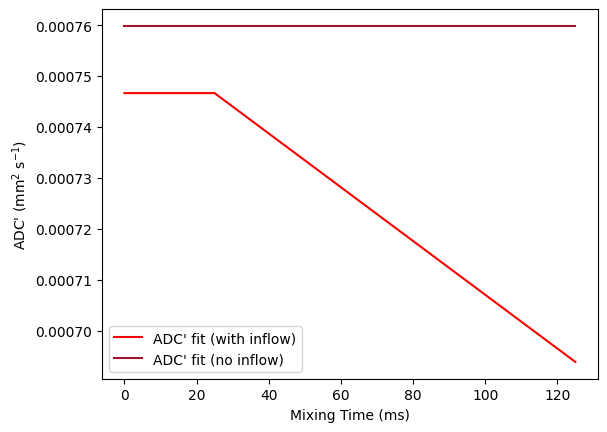

In [17]:
ADC_output, ADC_inflow_output, D1, D2, f1, k12, ratio = modelling_ADC_dash_with_crushers_inflow_v3(xdata, ahat_all)

# Prepare x-axis (mixing times)
tm_plot = np.concatenate(([0], xdata['tm']))  # prepend 0 for equilibrium point

# Prepare y-axis for plotting
y_ADC_inflow = np.concatenate(([ADC_inflow_output[0]], ADC_inflow_output[1]))
y_ADC = np.concatenate(([ADC_output[0]], ADC_output[1]))

plt.plot(tm_plot, y_ADC_inflow, 'r-', label="ADC' fit (with inflow)")
plt.plot(tm_plot, y_ADC, '-', color="#A2142F", label="ADC' fit (no inflow)")
plt.legend(loc='lower left')
# plt.annotate(f"v_b = {ahat_all[0]:.3f} mL mL$^{{-1}}$", (0.05, 0.95), xycoords='axes fraction')
# plt.annotate(f"k_w = {ahat_all[1]:.3f} s$^{{-1}}$", (0.05, 0.90), xycoords='axes fraction')
# plt.annotate(f"D* = {ahat_all[2]:.3f} mm$^{{-2}}$ s$^{{-1}}$", (0.05, 0.85), xycoords='axes fraction')
# plt.annotate(f"D_e = {ahat_all[3]:.5f} mm$^{{-2}}$ s$^{{-1}}$", (0.05, 0.80), xycoords='axes fraction')
# plt.annotate(f"Flow factor = {ahat_all[4]:.5f}", (0.05, 0.75), xycoords='axes fraction')
plt.xlabel('Mixing Time (ms)')
plt.ylabel("ADC' (mm$^2$ s$^{-1}$)")
plt.show()

In [21]:
# ydata is a dict, so to get the ADC array use ydata['ADC']
# Also, call the model function with (xdata, ahat_all) not (ahat_all, xdata)
ADC_output, ADC_inflow_output, *_ = modelling_ADC_dash_with_crushers_inflow_v3(xdata, ahat_all)

fits = {
    'f1': ahat_all[0],
    'k12': ahat_all[1],
    'D1': ahat_all[2],
    'D2': ahat_all[3],
    'inflow': ahat_all[4],
    'minimumresid': resnorm_all,
    'tms': np.concatenate(([xdata['tm'][0]], xdata['tm'])),
    'y': ydata['ADC'],
    'fits': ADC_inflow_output,
    'corrected_fit': ADC_output,
}


fits

{'f1': np.float64(0.04099972683583923),
 'k12': np.float64(0.9999999385721092),
 'D1': np.float64(0.01425600244230707),
 'D2': np.float64(0.0006934759225722597),
 'inflow': np.float64(1.0000029371419348),
 'minimumresid': np.float64(3.4986886063894164e-09),
 'tms': array([ 25,  25,  50,  75, 100, 125]),
 'y': array([0.00079268, 0.0007128 , 0.00072095, 0.00072746, 0.00070324,
        0.00069052]),
 'fits': [np.float64(0.0007466554034717405),
  array([0.00074666, 0.00073347, 0.00072028, 0.00070709, 0.0006939 ])],
 'corrected_fit': [np.float64(0.0007598453819835047),
  array([0.00075985, 0.00075985, 0.00075985, 0.00075985, 0.00075985])]}

In [2]:

import numpy as np
from scipy.linalg import expm

def modelling_ADC_dash_with_crushers_inflow_v3(xdata, params):

    f1 = params[0]  # f1 is the fraction of the first compartment
    k12 = params[1]  # k12 is the exchange rate between compartments
    D1 = params[2]  # D1 is the diffusion coefficient of the intravascular compartment
    D2 = params[3]  # D2 is the diffusion coefficient of the extravascular compartment
    ratio = params[4]  

    # Calculate D1 based on the model equation (the second line overwrites the first)
    D1 = (xdata['ADC_equil'] - (1 - f1) * D2) / f1

    tm = np.array(xdata['tm'])
    Ntm = xdata['ntm']
    b = np.array(xdata['b'])
    Nb = xdata['nb']
    td = xdata['td']
    bf = xdata['bf']
    deltac = xdata['deltac']
    dZ = xdata['dZ']
    dZ_slab = xdata['dZslab']
    bw_storage = xdata['bw_storage']
    gamma = xdata['gamma']
    ts = xdata['ts']

    # Output arrays
    ADC_f = np.zeros(Ntm)
    ADC_f_inflow = np.zeros(Ntm)
    ADC_nf = np.zeros(Ntm)
    ADC_nf_inflow = np.zeros(Ntm)

    if np.all(D1 > D2):
        # exchange matrix:
        K = np.array([[-k12, k12 * f1 / (1 - f1)], 
                      [k12, k12 * f1 / (1 - f1)]])
        # diffusion matrix
        D = np.diag([D1, D2])

        # inflow
        D_inflow = np.diag([D1 * 1e13, D2])

        # signal? ask Ben
        S0 = 1
        f = S0 * np.array([f1, (1 - f1)])

        # q due to the crusher and slice selection
        qc = 4 * np.pi / dZ + (np.pi * bw_storage * ts) / dZ

        # model Sf (ADC along the filter direction)
        Sf = expm(-bf * D + td * K) @ f

        # Preallocate signals
        S = np.zeros((Ntm, Nb))
        S_inflow = np.zeros((Ntm, Nb))
        Snf = np.zeros((Ntm, Nb))
        Snf_inflow = np.zeros((Ntm, Nb))

        for ntm in range(Ntm):
            # Calculate the signal for each mixing time
            Sm = expm((-(qc) ** 2 * D + K) * tm[ntm]) @ Sf
            Sm_inflow = expm((-(qc) ** 2 * D_inflow + K) * tm[ntm]) @ Sf

            # Crusher contribution without the filter
            Smnf = expm((-(qc) ** 2 * D + K) * tm[ntm]) @ f
            Smnf_inflow = expm((-(qc) ** 2 * D_inflow + K) * tm[ntm]) @ f

            for nb in range(Nb):
                # Calculate the signal for each b-value
                S[ntm, nb] = np.sum(expm(-b[nb] * D + td * K) @ Sm)
                S_inflow[ntm, nb] = np.sum(expm(-b[nb] * D + td * K) @ Sm_inflow)
                Snf[ntm, nb] = np.sum(expm(-b[nb] * D + td * K) @ Smnf)
                Snf_inflow[ntm, nb] = np.sum(expm(-b[nb] * D + td * K) @ Smnf_inflow)

            # Calculate the ADC values for each mixing time
            y_log = -np.log(S[ntm, :])
            ADC_f[ntm] = (y_log[1] - y_log[0]) / (b[1] - b[0])

            y_log_inflow = -np.log(S_inflow[ntm, :])
            ADC_f_inflow[ntm] = (y_log_inflow[1] - y_log_inflow[0]) / (b[1] - b[0])

            y_log_nf = -np.log(Snf[ntm, :])
            ADC_nf[ntm] = (y_log_nf[1] - y_log_nf[0]) / (b[1] - b[0])

            y_log_nf_inflow = -np.log(Snf_inflow[ntm, :])
            ADC_nf_inflow[ntm] = (y_log_nf_inflow[1] - y_log_nf_inflow[0]) / (b[1] - b[0])

        # Calculate fraction for inflow
        frac = ratio * tm / tm[-1]
        frac[frac > 1] = 1  
        frac[frac < 0] = 0  

        ADC_inflow_output = [(1 - frac[0]) * ADC_nf[0] + frac[0] * ADC_nf_inflow[0], (1 - frac) * ADC_f + frac * ADC_f_inflow]
        ADC_output = [ADC_nf[0], ADC_f]

    else:
        ADC_output = np.ones(len(tm) + 1)
        ADC_inflow_output = np.ones(len(tm) + 1)
    
    return ADC_output, ADC_inflow_output, D1, D2, f1, k12, ratio
     


